<a href="https://colab.research.google.com/github/eevvvaa/Deep_Generative_Model-HW/blob/week2/cGAN%E5%9C%A8%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E4%B8%8A%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Random seed fixed at 42
Device in use: cuda
Generator parameters: 1,623,312
Discriminator parameters: 3,438,593
Start Training!
Epoch [1/50] D_loss: 0.5221 | G_loss: 1.7356 | D_real_acc: 0.7165 | D_fake_acc: 0.8576 | Time: 15.37s
Epoch [2/50] D_loss: 0.4618 | G_loss: 1.8240 | D_real_acc: 0.7537 | D_fake_acc: 0.9265 | Time: 15.65s
Epoch [3/50] D_loss: 0.4075 | G_loss: 2.1426 | D_real_acc: 0.7987 | D_fake_acc: 0.9544 | Time: 15.43s
Epoch [4/50] D_loss: 0.3826 | G_loss: 2.4743 | D_real_acc: 0.8238 | D_fake_acc: 0.9652 | Time: 16.09s
Epoch [5/50] D_loss: 0.3912 | G_loss: 2.4963 | D_real_acc: 0.8192 | D_fake_acc: 0.9555 | Time: 15.28s
Epoch [6/50] D_loss: 0.5047 | G_loss: 1.6977 | D_real_acc: 0.6978 | D_fake_acc: 0.8792 | Time: 16.34s
Epoch [7/50] D_loss: 0.5533 | G_loss: 1.3984 | D_real_acc: 0.6386 | D_fake_acc: 0.8422 | Time: 15.37s
Epoch [8/50] D_loss: 0.5861 | G_loss: 1.2303 | D_real_acc: 0.5905 | D_fake_acc: 0.8241 | Time: 16.46s
Epoch [9/50] D_loss: 0.5982 | G_loss: 1.1962 | D_real_

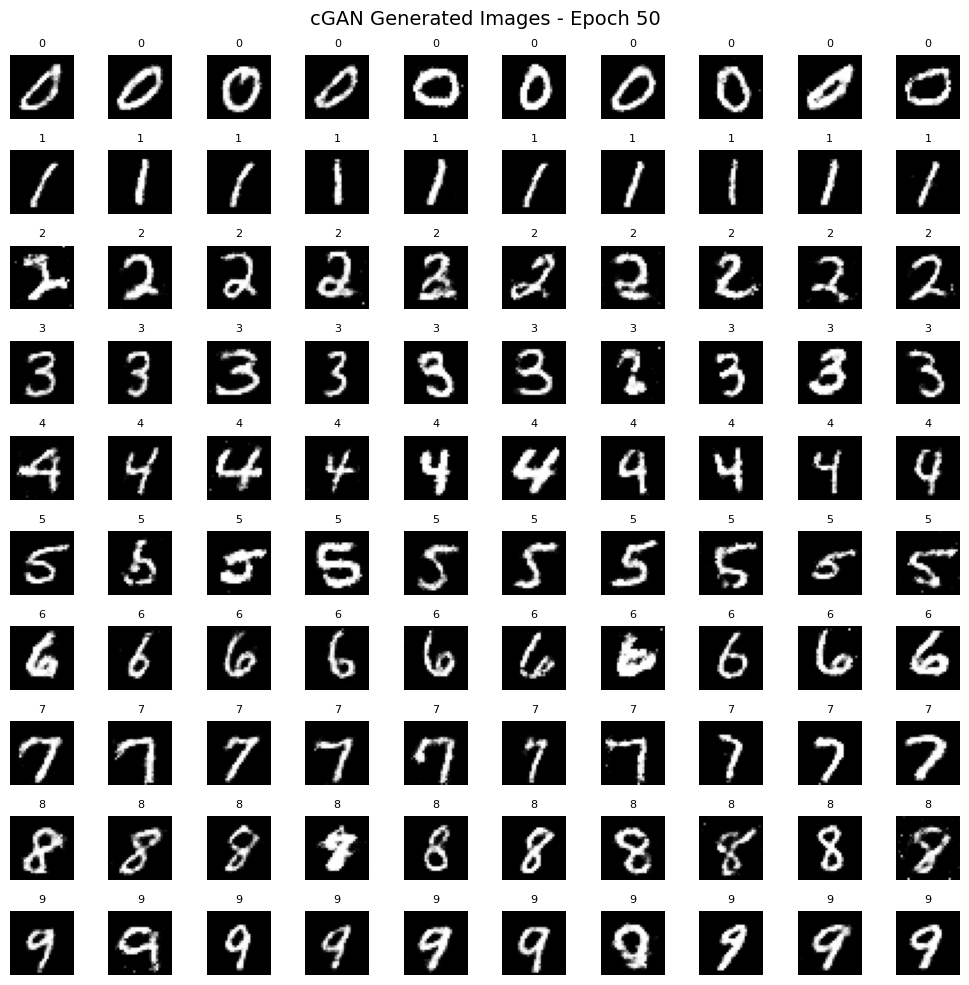

In [6]:
import os
import time
import random
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# ===============================
#  固定隨機種子 (重要!)
# ===============================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 若使用多 GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ Random seed fixed at {seed}")

set_seed(42)

# ===============================
#  生成器 (Generator)
# ===============================
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=784, hidden_dim=256, num_classes=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # 處理隨機噪聲的全連接層
        self.fc1_noise = nn.Linear(input_dim, hidden_dim)
        # 處理標籤的全連接層
        self.fc1_label = nn.Linear(num_classes, hidden_dim)

        # 主網路
        self.main = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(True),

            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(True),

            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        noise_out = F.relu(self.fc1_noise(noise))
        label_out = F.relu(self.fc1_label(labels))
        x = torch.cat([noise_out, label_out], dim=1)
        x = self.main(x)
        return x.view(-1, 1, 28, 28)


# ===============================
#  判別器 (Discriminator)
# ===============================
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, num_classes=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.fc1_image = nn.Linear(input_dim, hidden_dim * 4)
        self.fc1_label = nn.Linear(num_classes, hidden_dim * 4)

        self.main = nn.Sequential(
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        x = images.view(-1, self.input_dim)
        image_out = F.leaky_relu(self.fc1_image(x), 0.2)
        label_out = F.leaky_relu(self.fc1_label(labels), 0.2)
        x = torch.cat([image_out, label_out], dim=1)
        x = self.main(x)
        return x.squeeze()


# ===============================
#  設定環境與初始參數
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# 建立固定噪聲與標籤
def create_fixed_noise_and_labels():
    fixed_noise = torch.randn(100, 100).to(device)
    fixed_labels = torch.zeros(100, 10).to(device)
    for digit in range(10):
        for i in range(10):
            idx = digit * 10 + i
            fixed_labels[idx, digit] = 1.0
    return fixed_noise, fixed_labels

fixed_noise, fixed_labels = create_fixed_noise_and_labels()


# ===============================
#  結果可視化用函式
# ===============================
def show_result(num_epoch, show=False, save=False, path='result.png'):
    G.eval()
    with torch.no_grad():
        test_images = G(fixed_noise, fixed_labels)
    G.train()

    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            axes[i, j].imshow(test_images[idx].cpu().squeeze().numpy(), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{i}', fontsize=8)

    plt.suptitle(f'cGAN Generated Images - Epoch {num_epoch}', fontsize=14)
    plt.tight_layout()
    plt.savefig(path, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()


def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(hist['D_losses'], label='Discriminator Loss')
    plt.plot(hist['G_losses'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(hist['D_real_acc'], label='Real Accuracy')
    plt.plot(hist['D_fake_acc'], label='Fake Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Discriminator Accuracy')
    plt.grid(True)

    plt.tight_layout()
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()


# ===============================
#  訓練設定
# ===============================
batch_size = 128
lr = 0.0002
train_epoch = 50
label_smooth = 0.1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)
print(f"Generator parameters: {sum(p.numel() for p in G.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

criterion = nn.BCELoss()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

os.makedirs('MNIST_cGAN_results/Fixed_results', exist_ok=True)

train_hist = {'D_losses': [], 'G_losses': [], 'D_real_acc': [], 'D_fake_acc': [], 'per_epoch_ptimes': [], 'total_ptime': []}

print('Start Training!')
start_time = time.time()

# ===============================
#  模型訓練主迴圈
# ===============================
for epoch in range(train_epoch):
    D_losses, G_losses, D_real_accs, D_fake_accs = [], [], [], []
    epoch_start_time = time.time()

    for batch_idx, (real_images, real_labels) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        real_labels_onehot = F.one_hot(real_labels, num_classes=10).float().to(device)

        real_targets = torch.full((batch_size,), 1.0 - label_smooth, device=device)
        fake_targets = torch.zeros(batch_size, device=device)

        # === 訓練判別器 ===
        D.zero_grad()
        D_real_output = D(real_images, real_labels_onehot)
        D_real_loss = criterion(D_real_output, real_targets)
        D_real_acc = (D_real_output > 0.5).float().mean()

        noise = torch.randn(batch_size, 100, device=device)
        fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake_labels_onehot = F.one_hot(fake_labels, num_classes=10).float().to(device)
        fake_images = G(noise, fake_labels_onehot)

        D_fake_output = D(fake_images.detach(), fake_labels_onehot)
        D_fake_loss = criterion(D_fake_output, fake_targets)
        D_fake_acc = (D_fake_output < 0.5).float().mean()

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_total_loss.backward()
        D_optimizer.step()

        # === 訓練生成器 ===
        G.zero_grad()
        D_fake_output = D(fake_images, fake_labels_onehot)
        G_loss = criterion(D_fake_output, real_targets)
        G_loss.backward()
        G_optimizer.step()

        D_losses.append(D_total_loss.item())
        G_losses.append(G_loss.item())
        D_real_accs.append(D_real_acc.item())
        D_fake_accs.append(D_fake_acc.item())

    per_epoch_time = time.time() - epoch_start_time
    print(f'Epoch [{epoch+1}/{train_epoch}] '
          f'D_loss: {np.mean(D_losses):.4f} | '
          f'G_loss: {np.mean(G_losses):.4f} | '
          f'D_real_acc: {np.mean(D_real_accs):.4f} | '
          f'D_fake_acc: {np.mean(D_fake_accs):.4f} | '
          f'Time: {per_epoch_time:.2f}s')

    show_result(epoch+1, save=True, path=f'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_{epoch+1}.png')

    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['D_real_acc'].append(np.mean(D_real_accs))
    train_hist['D_fake_acc'].append(np.mean(D_fake_accs))
    train_hist['per_epoch_ptimes'].append(per_epoch_time)


# ===============================
#  訓練結束後顯示最後結果
# ===============================
end_time = time.time()
total_ptime = end_time - start_time
print(f'Training completed in {total_ptime / 60:.2f} min.')

show_result(train_epoch, show=True, path=f'MNIST_cGAN_results/Fixed_results/MNIST_cGAN_final.png')